In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as nplin
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.basicConfig(filename='convergence.tmp.log', level=logging.INFO)
logging.captureWarnings(True)

## Setup the True Parameters /  Simulation Parameters

In [4]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'phi':-.2,
               'scale': .1,
               'delta': 1.11,
               'rho': .6,
              }
time_dim = 3000
sim_dim = 1000

## Setup the linking functions.

In [5]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       phi=true_params['phi'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.psi(true_params['rho'], true_params['scale'], true_params['phi'], 
                  theta=true_params['equity_price']), 
     'phi_squared': true_params['phi']**2})

## We start by examining the distributions of simulated data

In [6]:
vl.__version__

'0.0.04-py36_0'

In [7]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

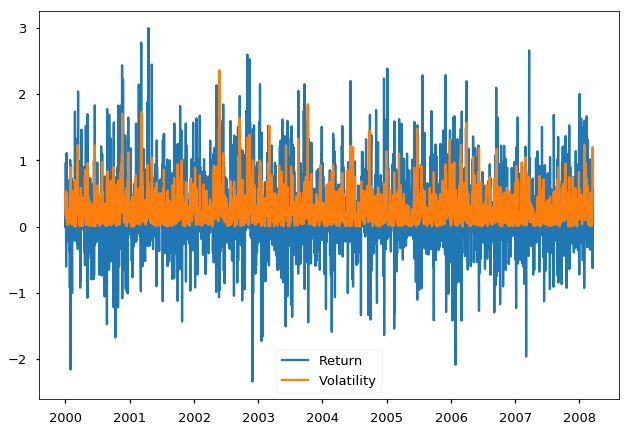

In [8]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


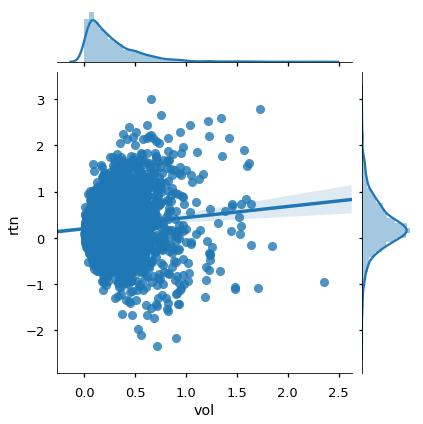

In [9]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [10]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.273230,0.263571
std,0.258469,0.565742
min,0.000068,-2.343037
25%,0.086436,-0.048347
50%,0.196652,0.213586
75%,0.377636,0.553778
max,2.358905,2.997537


## The Asymptotic Distributions in the Strongly Identified Case

In [11]:
def gen_data(x):
    return vl.simulate_data(time_dim=time_dim, **true_params) 

In [12]:
# with Pool(8) as pool:
data_arr = list(map(gen_data, tqdm.tnrange(sim_dim)))

In [13]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.estimate_params, data_arr), total=len(data_arr)))

Text(0.5,0,'delta')

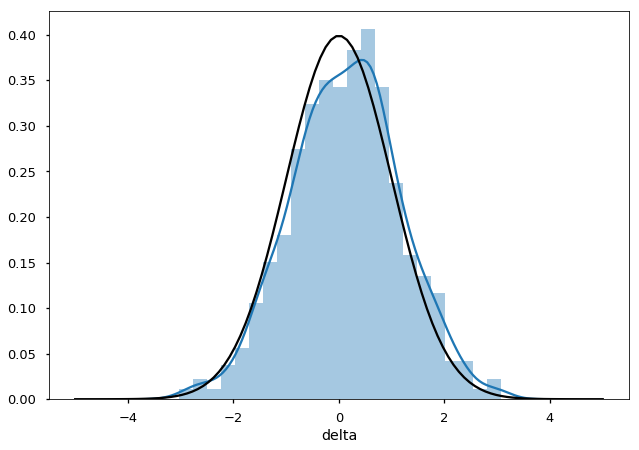

In [14]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot([(est['delta'] - true_params['delta']) / np.sqrt(cov.loc['delta','delta']) 
              for est, cov in est_arr], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

Text(0.5,0,'scale')

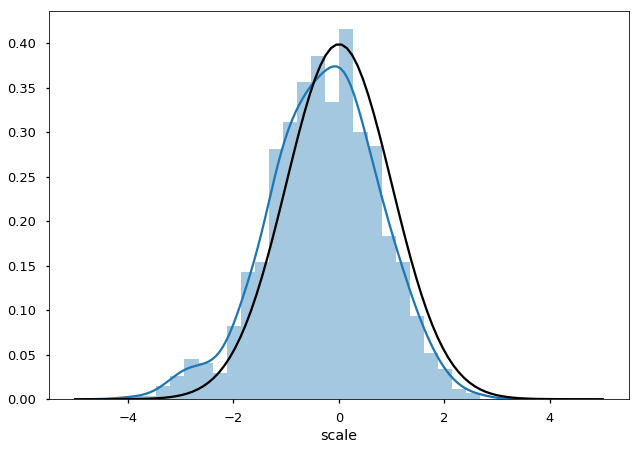

In [15]:
scale_fig, scale_ax = mpl.pyplot.subplots()
sns.distplot([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale']) 
              for est, cov in est_arr], ax=scale_ax)
scale_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
scale_ax.set_xlabel('scale')

Text(0.5,0,'rho')

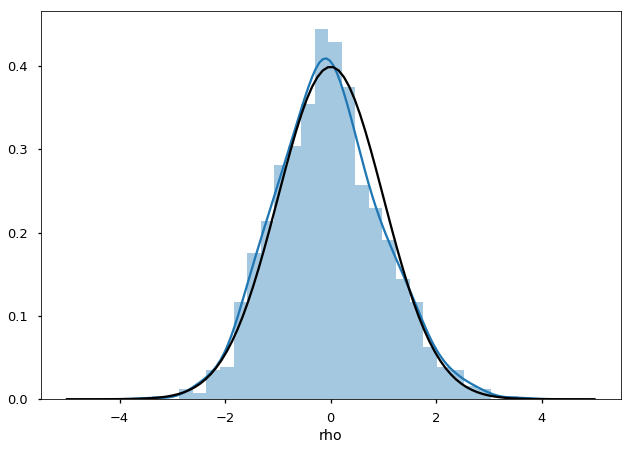

In [16]:
rho_fig, rho_ax = mpl.pyplot.subplots()
sns.distplot([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) 
              for est, cov in est_arr], ax=rho_ax)
rho_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
rho_ax.set_xlabel('rho')

Text(0.5,0,'equity price')

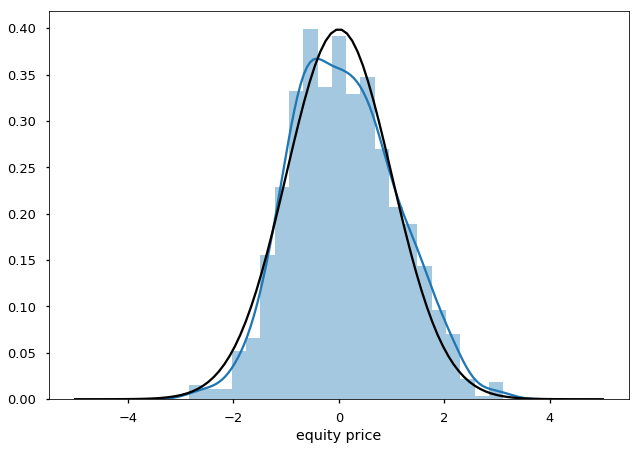

In [17]:
equity_price_fix, equity_price_ax = mpl.pyplot.subplots()
sns.distplot([(est['equity_price'] - true_params['equity_price']) / 
              np.sqrt(cov.loc['equity_price', 'equity_price']) for est, cov in est_arr], ax=equity_price_ax)
equity_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
equity_price_ax.set_xlabel('equity price')

Text(0.5,0,'vol_price')

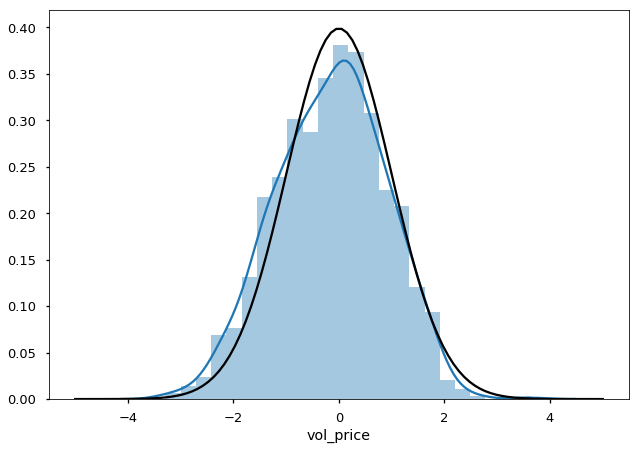

In [18]:
vol_price_fix, vol_price_ax = mpl.pyplot.subplots()
sns.distplot([(est['vol_price'] - true_params['vol_price']) / 
              np.sqrt(cov.loc['vol_price', 'vol_price']) for est, cov in est_arr], ax=vol_price_ax)
vol_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
vol_price_ax.set_xlabel('vol_price')

(-10, 10)

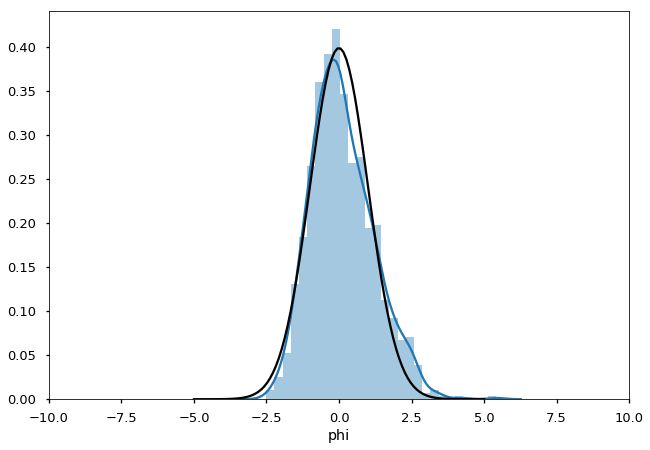

In [19]:
phi_fig, phi_ax = mpl.pyplot.subplots()
sns.distplot([(est['phi'] - true_params['phi']) / np.sqrt(cov.loc['phi', 'phi'])
              for est, cov in est_arr], ax=phi_ax)
phi_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
phi_ax.set_xlabel('phi')
phi_ax.set_xlim([-10,10])

In [24]:
import sympy as sym

In [28]:
from volpriceinference.volprice import beta_sym, gamma_sym

In [26]:
sym.init_printing()

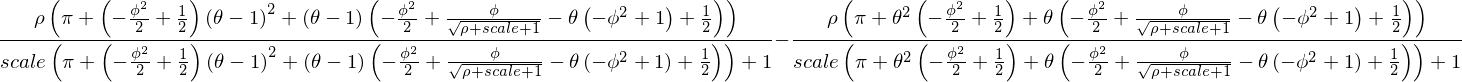

In [29]:
beta_sym

In [46]:
delta, phi, pi, psi, rho, scale, theta = sym.symbols('delta phi psi, pi rho scale theta')

In [47]:
true_params

{'equity_price': 0.5,
 'vol_price': -7,
 'phi': -0.2,
 'scale': 0.1,
 'delta': 1.11,
 'rho': 0.6}

In [125]:
link2 = sym.Matrix([beta_sym, gamma_sym]).replace(theta, (1 - phi**2)**(-1) * (psi - (phi / sym.sqrt(1 + rho) + ( 1 - phi**2)/2)))

In [126]:
link_pi_grad_in = sym.lambdify((delta, phi, pi, psi, rho, scale), link2.diff(delta))

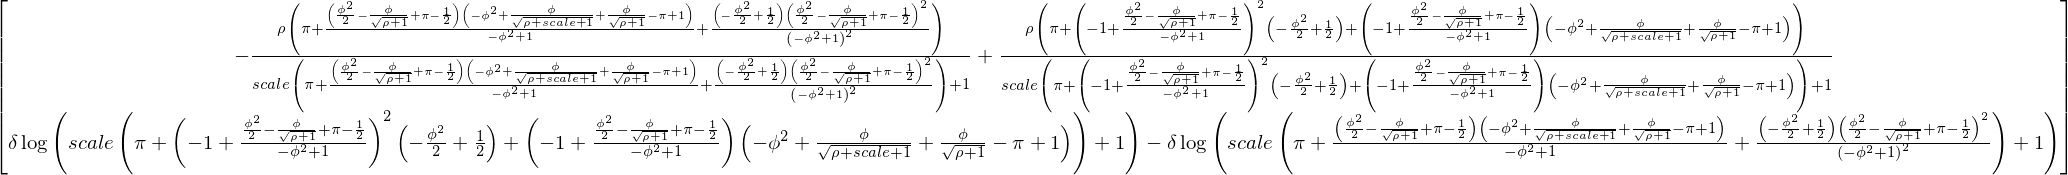

In [127]:
link2

In [128]:
def covariance_kernel(delta, phi, psi, rho, scale, vol_price1, vol_price2, reduced_form_cov):
    """ This function computes the covariance kernel """
    
    left_bread = link_pi_grad_in(delta=delta, phi=phi, pi=vol_price1, psi=psi, rho=rho, scale=scale).T
    right_bread = link_pi_grad_in(delta=delta, phi=phi, pi=vol_price2, psi=psi, rho=rho, scale=scale).T
    
    return left_bread, right_bread

In [129]:
reduced_est, reduced_cov = vl.compute_step2(data)

In [130]:
vol_est, vol_cov = vl.compute_vol_gmm(data.vol, init_constants=vl.compute_init_constants(data.vol))

In [131]:
reduced_cov2 = pd.merge(vol_cov, reduced_cov, how='outer', left_index=True, right_index=True).fillna(0).rename(columns={'phi_squared':'phi'}).rename(
    {'phi_squared':'phi'}).sort_index(axis=0).sort_index(axis=1)
reduced_cov2['phi'] *= 2 * np.sqrt(reduced_est['phi_squared'])
omega_cov = reduced_cov2.loc[['delta', 'phi',  'psi', 'rho', 'scale'], ['delta', 'phi',  'psi', 'rho', 'scale']]

In [132]:
omega_cov

,delta,phi,psi,rho,scale
delta,0.001872,0.000000,0.000000,-0.000416,-0.000065
phi,0.000000,0.742951,0.000000,0.000000,0.000000
psi,0.000000,0.000000,0.001783,0.000000,0.000000
rho,-0.000416,0.000000,0.000000,0.000367,-0.000018
scale,-0.000065,0.000000,0.000000,-0.000018,0.000013


In [133]:
true_params

{'equity_price': 0.5,
 'vol_price': -7,
 'phi': -0.2,
 'scale': 0.1,
 'delta': 1.11,
 'rho': 0.6}

In [134]:
reduced_est['psi']

In [135]:
covariance_kernel(delta=0.11, rho=.6, phi=-.2, vol_price1=-7, vol_price2=-2, psi=reduced_est['psi'], scale=.1, reduced_form_cov=omega_cov)

(array([[ 0., nan]]), array([[0.   , 0.034]]))